# Test Detection: YOLO-OBB (M1) + OBB Cropping (M2)

This notebook tests the first two stages of the AI Inspector pipeline:

- **M1 -- YOLODetector**: Runs YOLO11-OBB inference on a drawing page image and
  returns oriented bounding boxes around engineering callouts (Holes, TappedHoles,
  Fillets, Chamfers, etc.).
- **M2 -- OBB Cropper**: Takes each OBB detection and crops it from the source
  image, applying padding and minimum-size constraints.

**Runtime requirement:** GPU (A100 preferred, T4 acceptable).

**Outputs:**
- Detection summary (class counts, confidence statistics)
- Cropped callout images saved to `debug/crops/`
- Visual grid of all crops

In [1]:
# Cell 1: Install dependencies
# NOTE: Set your runtime to GPU before running (Runtime > Change runtime type > A100)
%pip install ultralytics pillow matplotlib --quiet

# Clone the repo
!git clone https://github.com/skaumbdoallsaws-coder/AI-Drawing-Inspector.git /content/AI-Drawing-Inspector 2>/dev/null || \
    (cd /content/AI-Drawing-Inspector && git pull)

print("Dependencies installed.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 72.2 MB/s eta 0:00:00
Dependencies installed.


In [6]:
import sys
import os

# Skip mounting Drive since it is failing and we can use local upload.
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)

# Add repo to Python path
sys.path.insert(0, '/content/AI-Drawing-Inspector')

# ---- Configure these paths ----
# Model from HuggingFace (finetuned YOLO11s-OBB)
MODEL_PATH = 'hf://shadrack20s/ai-inspector-callout-detection/callout_v2_yolo11s-obb_best.pt'

# Output directory (crops will be saved here)
OUTPUT_DIR = '/content/debug/crops'

os.makedirs(OUTPUT_DIR, exist_ok=True)

print(f'Model path:  {MODEL_PATH}')
print(f'Output dir:   {OUTPUT_DIR}')
print('Google Drive mount skipped. Proceeding with local file upload.')

Model path:  hf://shadrack20s/ai-inspector-callout-detection/callout_v2_yolo11s-obb_best.pt
Output dir:   /content/debug/crops
Google Drive mount skipped. Proceeding with local file upload.


In [7]:
# Cell 3: Import ai_inspector detection modules
from ai_inspector.detection.yolo_detector import YOLODetector
from ai_inspector.detection.classes import IDX_TO_CLASS, YOLO_CLASSES, FUTURE_TYPES
from ai_inspector.extractors.cropper import crop_obb, crop_detections
from ai_inspector.contracts import DetectionResult, CropResult
from PIL import Image
import numpy as np

print(f'YOLO classes ({len(YOLO_CLASSES)}): {YOLO_CLASSES}')
print(f'Future types (skipped in matching): {FUTURE_TYPES}')
print('Imports OK.')

YOLO classes (14): ['Hole', 'TappedHole', 'CounterboreHole', 'CountersinkHole', 'Fillet', 'Chamfer', 'Thread', 'Slot', 'Bend', 'GDT', 'SurfaceFinish', 'Dimension', 'Tolerance', 'Note']
Future types (skipped in matching): {'Tolerance', 'CountersinkHole', 'Thread', 'Note', 'Dimension', 'CounterboreHole', 'SurfaceFinish', 'GDT', 'Bend', 'Slot'}
Imports OK.


In [8]:
from google.colab import files
import os

print('Please upload your sample image now.')
uploaded = files.upload()

if uploaded:
    # Assuming only one file is uploaded for simplicity
    uploaded_filename = list(uploaded.keys())[0]
    # Move the uploaded file to a known location if needed, or use its current path
    global SAMPLE_IMAGE
    SAMPLE_IMAGE = os.path.join('/content/', uploaded_filename)
    print(f'Uploaded file: {SAMPLE_IMAGE}')
    print(f'Image exists: {os.path.exists(SAMPLE_IMAGE)}')
else:
    raise FileNotFoundError("No file was uploaded. Please upload a sample image.")

Please upload your sample image now.


Saving 00595601_04.png to 00595601_04.png
Uploaded file: /content/00595601_04.png
Image exists: True


In [10]:
# Cell 4: Load YOLO model and run detection on sample image
from huggingface_hub import hf_hub_download
import os

# Download model if it's a HuggingFace path
if MODEL_PATH.startswith('hf://'):
    print(f"Downloading model from {MODEL_PATH}...")
    # Manual parsing for the known path structure
    # MODEL_PATH = 'hf://shadrack20s/ai-inspector-callout-detection/callout_v2_yolo11s-obb_best.pt'
    repo_id = "shadrack20s/ai-inspector-callout-detection"
    filename = "callout_v2_yolo11s-obb_best.pt"

    local_model_path = hf_hub_download(repo_id=repo_id, filename=filename)
    print(f"Model downloaded to: {local_model_path}")
else:
    local_model_path = MODEL_PATH

detector = YOLODetector(
    model_path=local_model_path,
    confidence_threshold=0.25,
    device='cuda',
)
detector.load()
print(f'Model loaded: {detector.is_loaded}')

# Load test image
image = Image.open(SAMPLE_IMAGE).convert('RGB')
print(f'Image size: {image.size}')

# Run detection
detections = detector.detect(image, page_id='test_page_0')
print(f'\nDetections found: {len(detections)}')
if not detections:
    print('WARNING: No detections found. Try a lower confidence threshold (e.g., 0.15) or verify model/image path.')

# Show first 5 detections
for i, det in enumerate(detections[:5]):
    print(f'  [{i}] {det.class_name:20s} conf={det.confidence:.3f} id={det.det_id}')

callout_v2_yolo11s-obb_best.pt:   0%|          | 0.00/20.6M [00:00<?, ?B/s]

Model downloaded to: /root/.cache/huggingface/hub/models--shadrack20s--ai-inspector-callout-detection/snapshots/be362ec30b9128a3a0b83e7e4af4f8f1c6731f19/callout_v2_yolo11s-obb_best.pt
Model loaded: True
Image size: (1469, 951)

Detections found: 5
  [0] Fillet               conf=0.879 id=test_page_0_0
  [1] Hole                 conf=0.695 id=test_page_0_1
  [2] Hole                 conf=0.500 id=test_page_0_2
  [3] Hole                 conf=0.442 id=test_page_0_3
  [4] Chamfer              conf=0.397 id=test_page_0_4


In [11]:
# Cell 5: Run OBB cropping on detections, save crops to debug/crops/
crops = crop_detections(image, detections, pad_ratio=0.15)
print(f'Crops generated: {len(crops)}')

# Save each crop
for i, (det, crop) in enumerate(zip(detections, crops)):
    crop_path = f'{OUTPUT_DIR}/{det.det_id}_{det.class_name}.png'
    crop.image.save(crop_path)
    print(f'  [{i}] {det.class_name:20s} crop_size={crop.image.size}  '
          f'angle={crop.meta.get("rotation_angle", 0):.1f}deg  '
          f'saved={crop_path}')

print(f'\nAll crops saved to {OUTPUT_DIR}/')

Crops generated: 5
  [0] Fillet               crop_size=(190, 43)  angle=-1.2deg  saved=/content/debug/crops/test_page_0_0_Fillet.png
  [1] Hole                 crop_size=(64, 44)  angle=-0.1deg  saved=/content/debug/crops/test_page_0_1_Hole.png
  [2] Hole                 crop_size=(71, 44)  angle=-0.6deg  saved=/content/debug/crops/test_page_0_2_Hole.png
  [3] Hole                 crop_size=(130, 33)  angle=-0.2deg  saved=/content/debug/crops/test_page_0_3_Hole.png
  [4] Chamfer              crop_size=(133, 34)  angle=-1.1deg  saved=/content/debug/crops/test_page_0_4_Chamfer.png

All crops saved to /content/debug/crops/


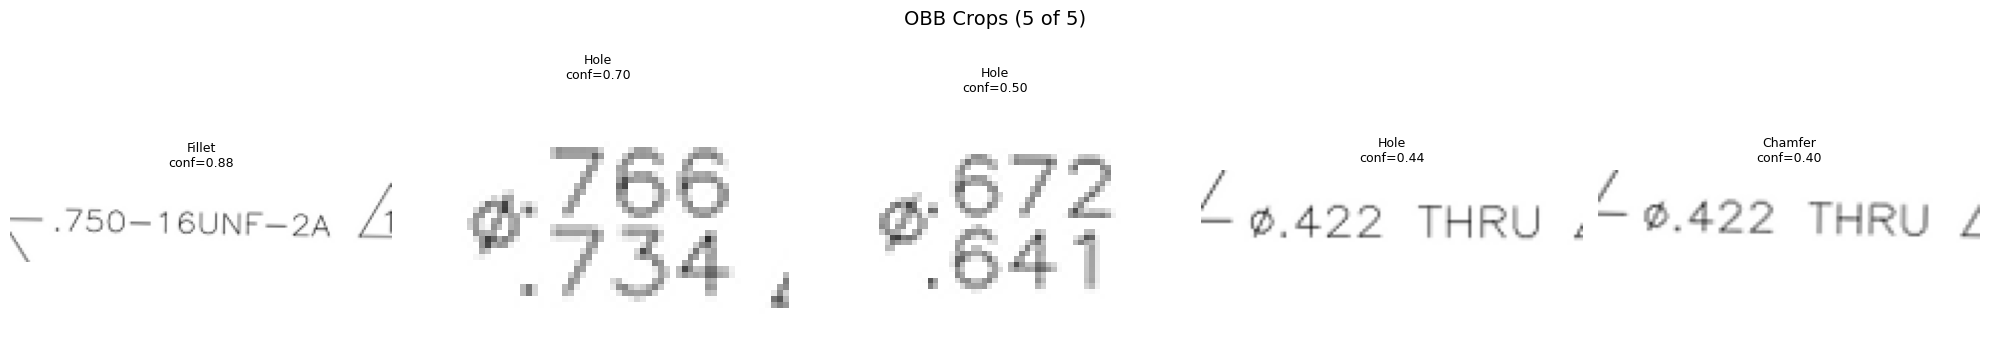

In [12]:
# Cell 6: Display crop results in a grid
import matplotlib.pyplot as plt
import math

n_crops = min(len(crops), 20)  # Show at most 20 crops
if n_crops == 0:
    print('No crops to display.')
else:
    cols = 5
    rows = math.ceil(n_crops / cols)
    fig, axes = plt.subplots(rows, cols, figsize=(4 * cols, 4 * rows))
    axes = np.array(axes).flatten() if n_crops > 1 else [axes]

    for i in range(n_crops):
        ax = axes[i]
        ax.imshow(crops[i].image)
        ax.set_title(
            f'{detections[i].class_name}\n'
            f'conf={detections[i].confidence:.2f}',
            fontsize=9,
        )
        ax.axis('off')

    # Hide unused axes
    for j in range(n_crops, len(axes)):
        axes[j].axis('off')

    plt.suptitle(f'OBB Crops ({n_crops} of {len(crops)})', fontsize=14)
    plt.tight_layout()
    plt.show()

In [14]:
# Cell 7: Print detection summary (class counts, confidence stats)
from collections import Counter

summary = detector.summary(detections)
print('=== Detection Summary ===')
print(f'Total detections: {summary["total"]}')
print(f'Average confidence: {summary["avg_confidence"]:.3f}')
print()

# Per-class breakdown
print(f'{"Class":25s} {"Count":>6s} {"Avg Conf":>10s} {"Min Conf":>10s} {"Max Conf":>10s}')
print('-' * 65)

class_groups = {}
for det in detections:
    cls = det.class_name
    if cls not in class_groups:
        class_groups[cls] = []
    class_groups[cls].append(det.confidence)

for cls in sorted(class_groups.keys()):
    confs = class_groups[cls]
    print(f'{cls:25s} {len(confs):6d} {sum(confs)/len(confs):10.3f} '
          f'{min(confs):10.3f} {max(confs):10.3f}')

# Confidence histogram
all_confs = [d.confidence for d in detections]
if all_confs:
    print(f'\nConfidence distribution:')
    for threshold in [0.9, 0.75, 0.5, 0.25]:
        count = sum(1 for c in all_confs if c >= threshold)
        print(f'  >= {threshold:.2f}: {count}/{len(all_confs)}')

# Cleanup
detector.unload()
print('\nDetector unloaded.')

=== Detection Summary ===
Total detections: 5
Average confidence: 0.582

Class                      Count   Avg Conf   Min Conf   Max Conf
-----------------------------------------------------------------
Chamfer                        1      0.397      0.397      0.397
Fillet                         1      0.879      0.879      0.879
Hole                           3      0.546      0.442      0.695

Confidence distribution:
  >= 0.90: 0/5
  >= 0.75: 1/5
  >= 0.50: 2/5
  >= 0.25: 5/5

Detector unloaded.
